#### Copyright (C) 2020 Sobhan Moradiyan Daghigh - All Rights Reserved
### Implementation of a Hierarchical Agglomerative Clustering on a professors' fields dataset
### Using spaCy model which is based on nlp and is very commen in text semantic similarities
##### 12/5/2020

### Hii. 

In [1]:
# !pip install spacy

In [2]:
# !python -m spacy download en_core_web_md

In [3]:
# !python -m spacy link en_core_web_md en

In [4]:
import pandas as pd
import numpy as np
import pickle
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import spacy

# I'm gonna use medium size of this model
nlp = spacy.load('en_core_web_md')

### Reading dataset

In [5]:
main_dataset = pd.read_excel("./Eng-Faculty.xlsx")
main_dataset.head()

,شناسه,نام,نام خانوادگی,Name,Family,جنسیت,دانشکده,گروه آموزشی,مقطع تحصیلی,رشته تحصیلی,...,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,21,جواد,ابوالفضلی اصفهانی,Javad,Abolfazli Esfahani,مرد,مهندسی,مهندسی مکانیک,دکترای تخصصی (PhD),مهندسی مکانیک (حرارت وسیالات ),...,Entropy generation,Heat transfer,Reynolds number,Lattice Boltzmann method,Natural convection,Nanofluids,Finite volume method,Turbulent flow,Heat and mass transfer,Micro-combustor
1,363,محمد,پسندیده فرد,Mohammad,Passandideh-Fard,مرد,مهندسی,مهندسی مکانیک,دکترای تخصصی (PhD),مکانیک,...,Nanofluids,Photovoltaic thermal systems,Free-surface flow,Solidification,Navier Stokes equations,Photovoltaic thermals,Heat transfer,Phase change materials,Vof Method,Exergy
2,111,محمدهادی,مؤید,Mohammad Hadi,Moayed,مرد,مهندسی,مهندسی متالورژی و مواد,دکترای تخصصی (PhD),مواد,...,Stainless steel,Pitting,Corrosion,A. Stainless steel,C. Pitting corrosion,Pitting corrosion,B. Polarisation,Polarization,Critical pitting temperatures,Polarisation
3,1392,سیدعبدالکریم,سجادی,Seyed Abdolkarim,Sajjadi,مرد,مهندسی,مهندسی متالورژی و مواد,دکترای تخصصی (PhD),مهندسی مواد,...,Nanocomposite,Microstructure,Superalloys,Mechanical alloying,Spark plasma sintering,Mechanical properties,Hardness,Aluminum,Sintering,Stir-Casting
4,665,علی,داودی,Ali,Davoodi,مرد,مهندسی,مهندسی متالورژی و مواد,دکترای تخصصی (PhD),مهندسی مواد - خوردگی,...,Corrosion,Corrosion resistance,Electrochemical impedance spectroscopy,Electrochemical corrosion,Polarization,Localized corrosion,Afm,Galvanic Corrosion,Eis,Atomic force microscopy


In [7]:
main_dataset.isna().sum()

شناسه            0
نام              0
نام خانوادگی     0
Name             0
Family           0
جنسیت            0
دانشکده          0
گروه آموزشی      0
مقطع تحصیلی      0
رشته تحصیلی      0
رتبه علمی        0
نوع هیات علمی    0
Field 1          5
Field 2          5
Field 3          5
Field 4          5
Field 5          5
Field 6          5
Field 7          5
Field 8          5
Field 9          5
Field 10         5
dtype: int64

### Dropping that 5 missing values

In [8]:
main_dataset.dropna(inplace=True)
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   شناسه          175 non-null    int64 
 1   نام            175 non-null    object
 2   نام خانوادگی   175 non-null    object
 3   Name           175 non-null    object
 4   Family         175 non-null    object
 5   جنسیت          175 non-null    object
 6   دانشکده        175 non-null    object
 7   گروه آموزشی    175 non-null    object
 8   مقطع تحصیلی    175 non-null    object
 9   رشته تحصیلی    175 non-null    object
 10  رتبه علمی      175 non-null    object
 11  نوع هیات علمی  175 non-null    object
 12  Field 1        175 non-null    object
 13  Field 2        175 non-null    object
 14  Field 3        175 non-null    object
 15  Field 4        175 non-null    object
 16  Field 5        175 non-null    object
 17  Field 6        175 non-null    object
 18  Field 7        175 non-null   

In [23]:
groups = main_dataset.groupby(by='گروه آموزشی')
for grp, pdf in groups:
    with pd.ExcelWriter('SeperatedEngineeringDepartments.xlsx', mode='a') as writer:
        pd.DataFrame(pdf).to_excel(writer, sheet_name=grp)

In [28]:
departments = []
groups = main_dataset.groupby(by='گروه آموزشی')
for grp, pdf in groups:
    with pd.ExcelFile('SeperatedEngineeringDepartments.xlsx') as reader:
        department = pd.read_excel(reader, sheet_name=grp)
        departments.append(department)

### As I'll explain more accurate about the spaCy, I need to merge the features for calculating the similarities


In [10]:
def connect_features(dataset):
    dataset['Fields'] = dataset[['Field 1', 'Field 2', 'Field 3', 'Field 4', 'Field 5',
                                 'Field 6', 'Field 7', 'Field 8', 'Field 9', 'Field 10']].agg(' - '.join, axis=1)
    return dataset

### Now I need a single column which contains all featurs 

In [29]:
new_departments = []
for department in departments:
    department = connect_features(department)
    new_departments.append(department)

### Here, the most important part of the code, I'll calculate the distance using spaCy 
### spaCy is a model for word vectorization based on semantic similarity 
#### For more info about spaCy click [here](https://spacy.io/usage/vectors-similarity).

In [12]:
def spacy_semantic_similarity(sentence1, sentence2):
    sentence1 = nlp(sentence1)
    sentence2 = nlp(sentence2)
    
    return sentence1.similarity(sentence2)

### Theres some examples to get more about spaCy

In [13]:
spacy_semantic_similarity('dog', 'cat')

0.8016854705531046

In [14]:
spacy_semantic_similarity('pen', 'pencil')

0.7085842403739737

### Combination of them

In [15]:
spacy_semantic_similarity('dog-pen', 'cat-pencil')

0.8442632419880388

### Check the preority
#### > No preority

In [16]:
spacy_semantic_similarity('dog-pen', 'pencil-cat')

0.8442632438866646

In [17]:
spacy_semantic_similarity('machine-learning', 'computer-vision')

0.7301827683773489

In [18]:
spacy_semantic_similarity('machine-learning', 'data-mining')

0.5259379727863402

In [19]:
spacy_semantic_similarity('machine-learning', 'Bioavailability')

0.05298170429970831

### Ok, now try to make the similarity matrix for dataset
#### Notice: This matrix's gonna take a little more time to be made
#### So as an advice, for more usage, save it as a peakle file 

In [47]:
similarity_matrixs = []
for department in new_departments:
    similarity_matrix = np.zeros((department.shape[0], department.shape[0]))
    for index1, person1 in department.iterrows():
        for index2, person2 in department.iterrows():
            if index2 > index1:
                similarity_matrix[index1, index2] = spacy_semantic_similarity(person1['Fields'], person2['Fields'])
            if index2 == index1:
                similarity_matrix[index1, index1] = 1
    similarity_matrixs.append(similarity_matrix)

In [48]:
new_similarity_matrixs = []
for similarity_matrix in similarity_matrixs:
    new_similarity_matrixs.append(similarity_matrix + similarity_matrix.T - np.diag(np.diag(similarity_matrix)))

In [49]:
new_similarity_matrixs[0]

array([[1.        , 0.85162494, 0.83565413, ..., 0.78061541, 0.84100626,
        0.71486703],
       [0.85162494, 1.        , 0.83960851, ..., 0.83756284, 0.90683463,
        0.82736576],
       [0.83565413, 0.83960851, 1.        , ..., 0.83820518, 0.89536765,
        0.75626832],
       ...,
       [0.78061541, 0.83756284, 0.83820518, ..., 1.        , 0.8839987 ,
        0.85219409],
       [0.84100626, 0.90683463, 0.89536765, ..., 0.8839987 , 1.        ,
        0.84424193],
       [0.71486703, 0.82736576, 0.75626832, ..., 0.85219409, 0.84424193,
        1.        ]])

### Here we go :)

### Now try to make a dendrogram to have a good visualization on datas
### Then decide number of clusters

### Fisrt, I'm gonna use 'complete' method for agglomerative clustering 

In [50]:
new_similarity_matrixs[5]

array([[1.        , 0.92748629, 0.91109187, ..., 0.90610916, 0.88636111,
        0.77917411],
       [0.92748629, 1.        , 0.93073425, ..., 0.90605324, 0.90547905,
        0.77643354],
       [0.91109187, 0.93073425, 1.        , ..., 0.92877155, 0.9214145 ,
        0.74815012],
       ...,
       [0.90610916, 0.90605324, 0.92877155, ..., 1.        , 0.93696588,
        0.81786456],
       [0.88636111, 0.90547905, 0.9214145 , ..., 0.93696588, 1.        ,
        0.79635593],
       [0.77917411, 0.77643354, 0.74815012, ..., 0.81786456, 0.79635593,
        1.        ]])

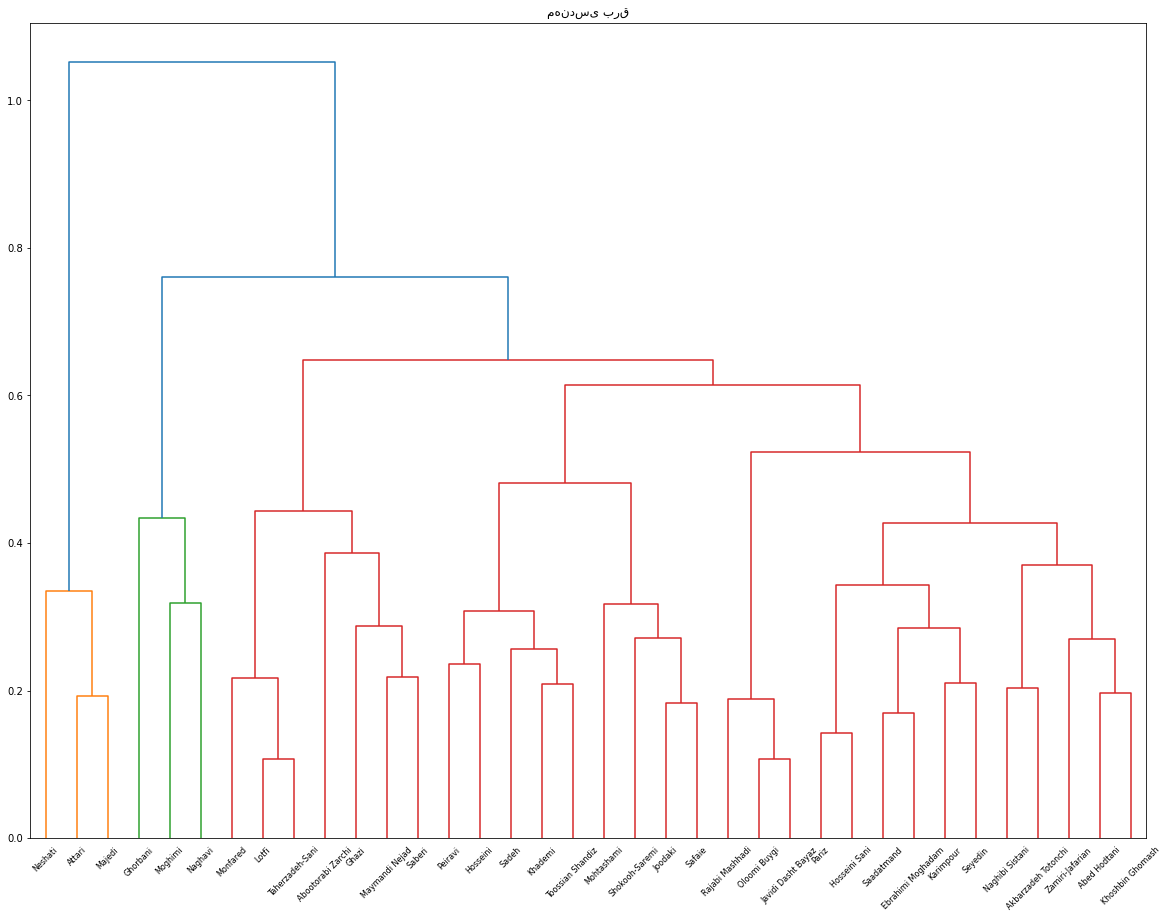

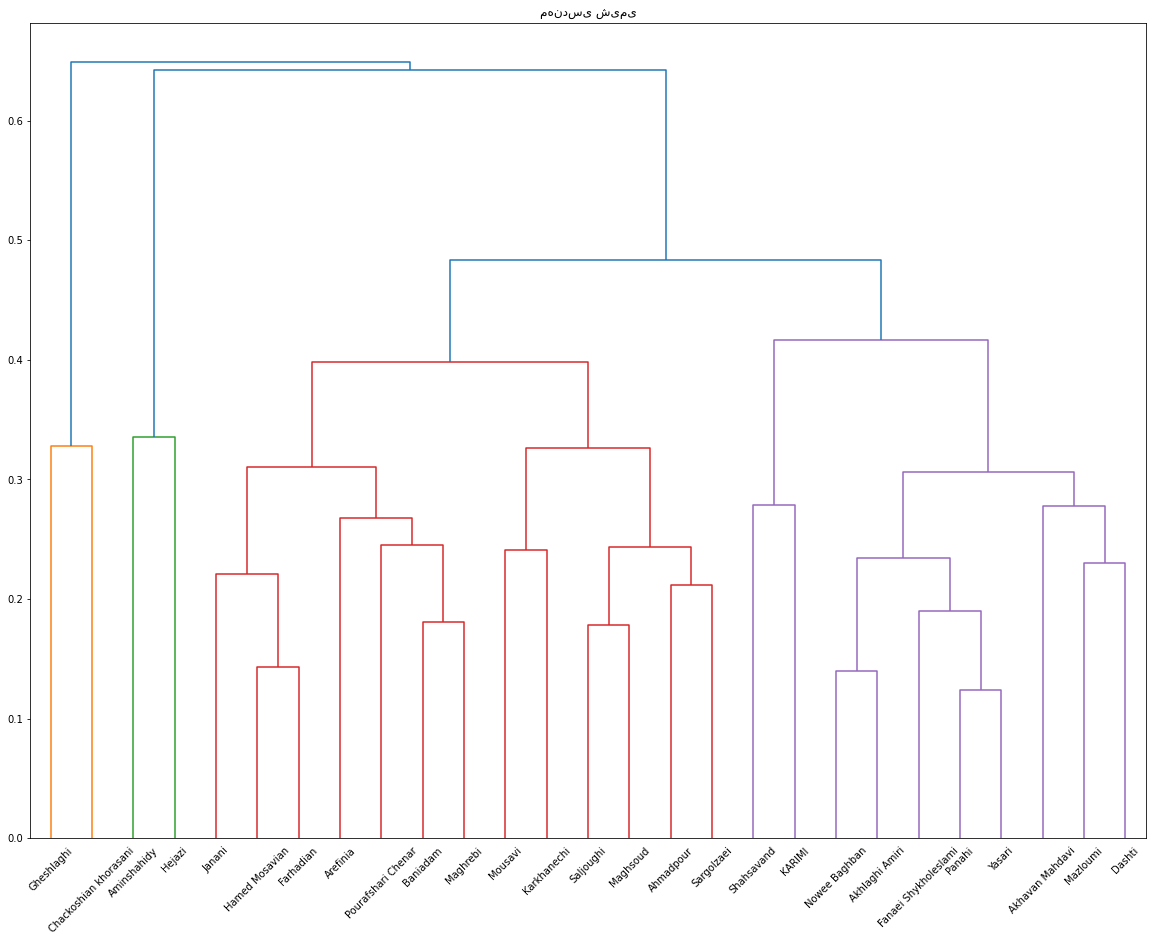

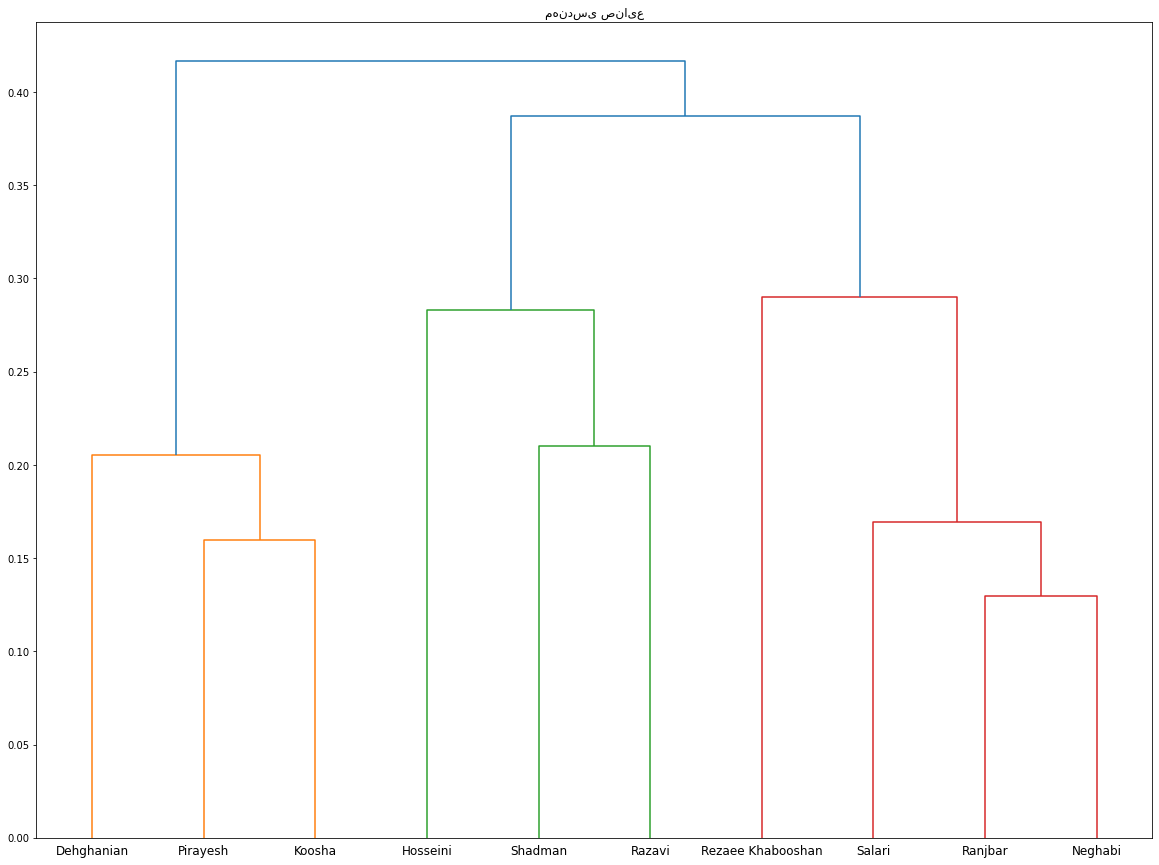

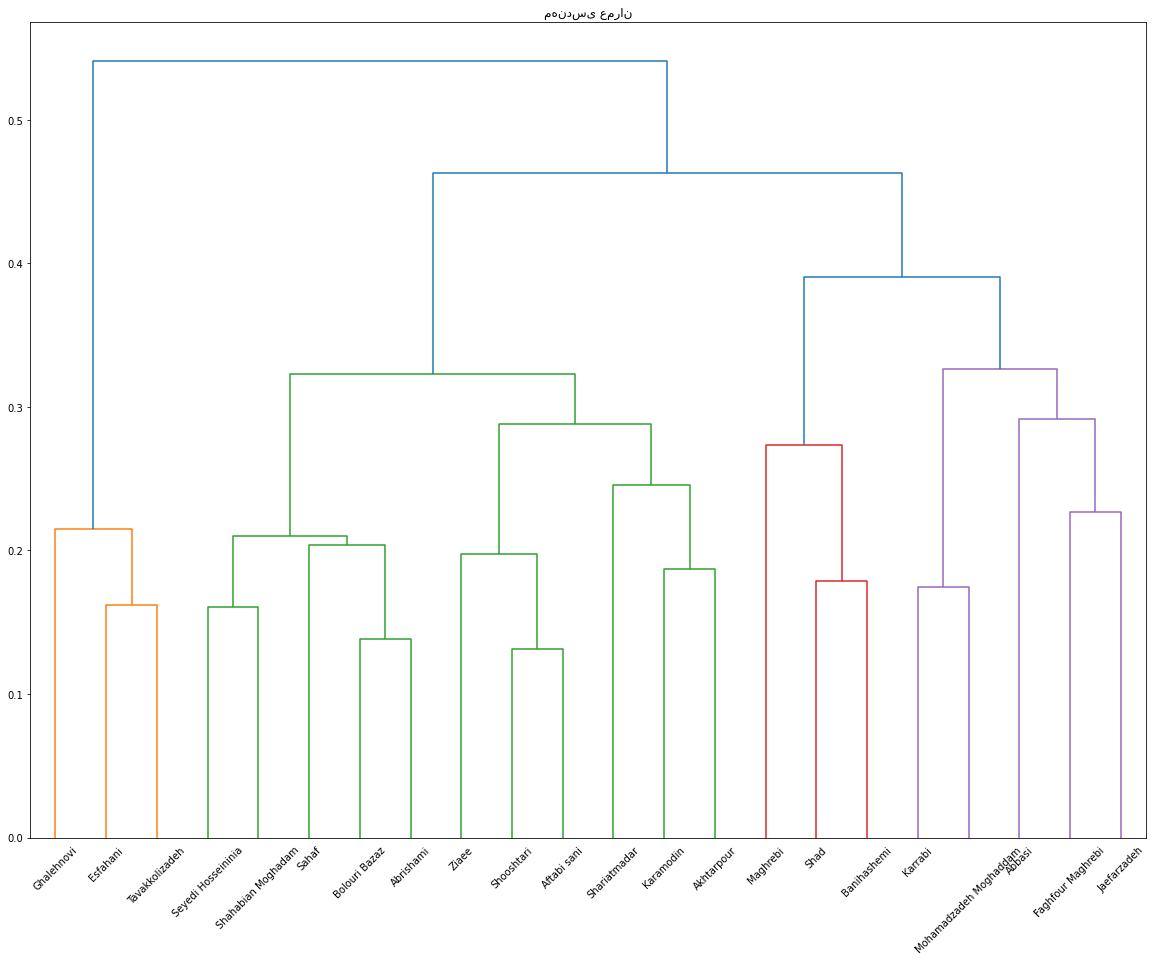

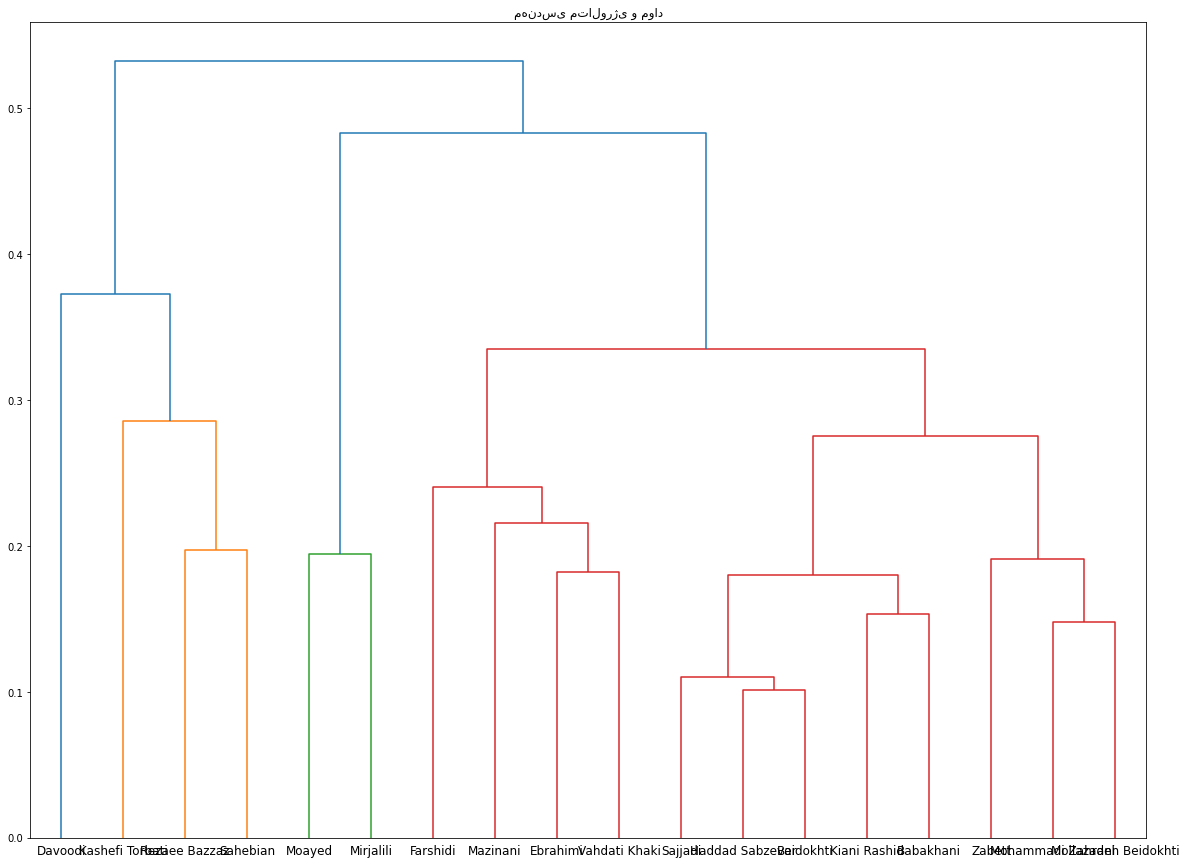

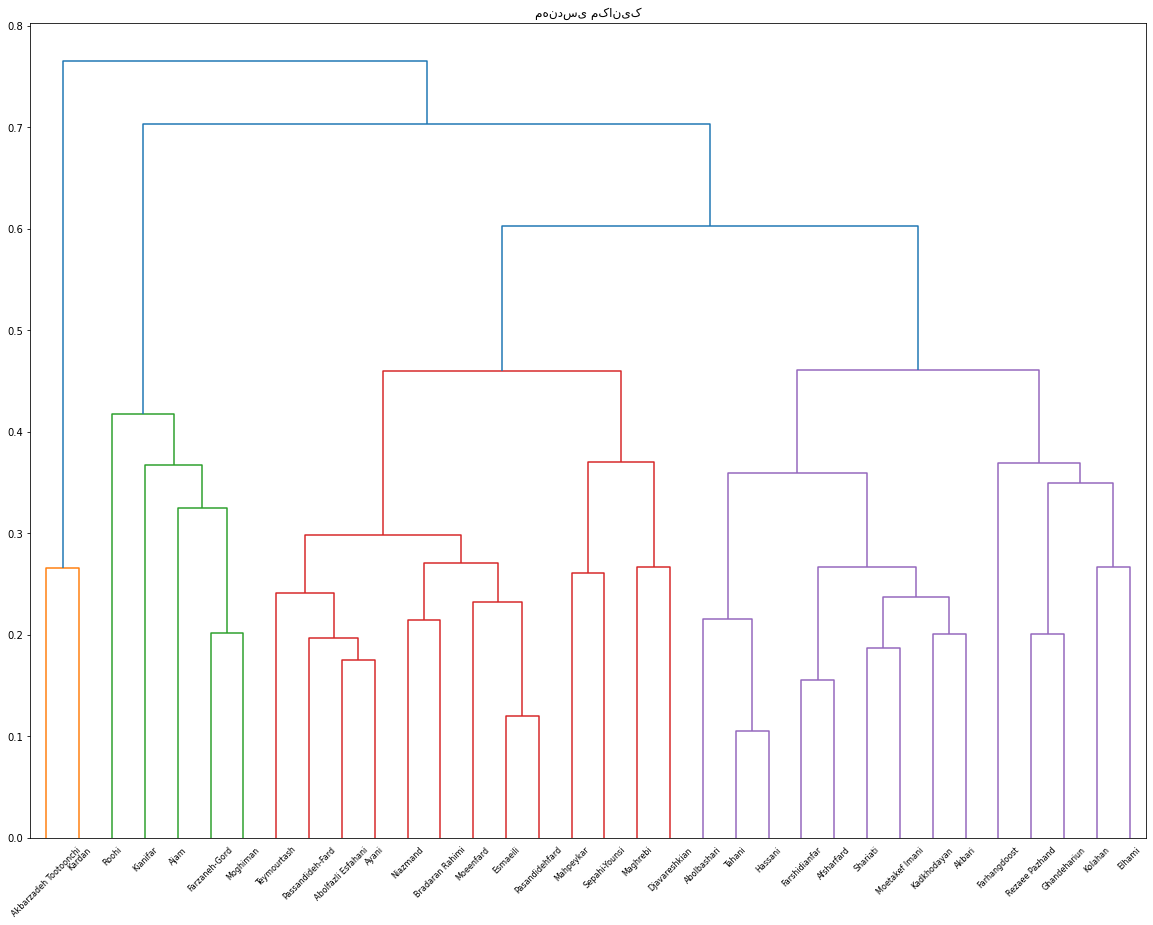

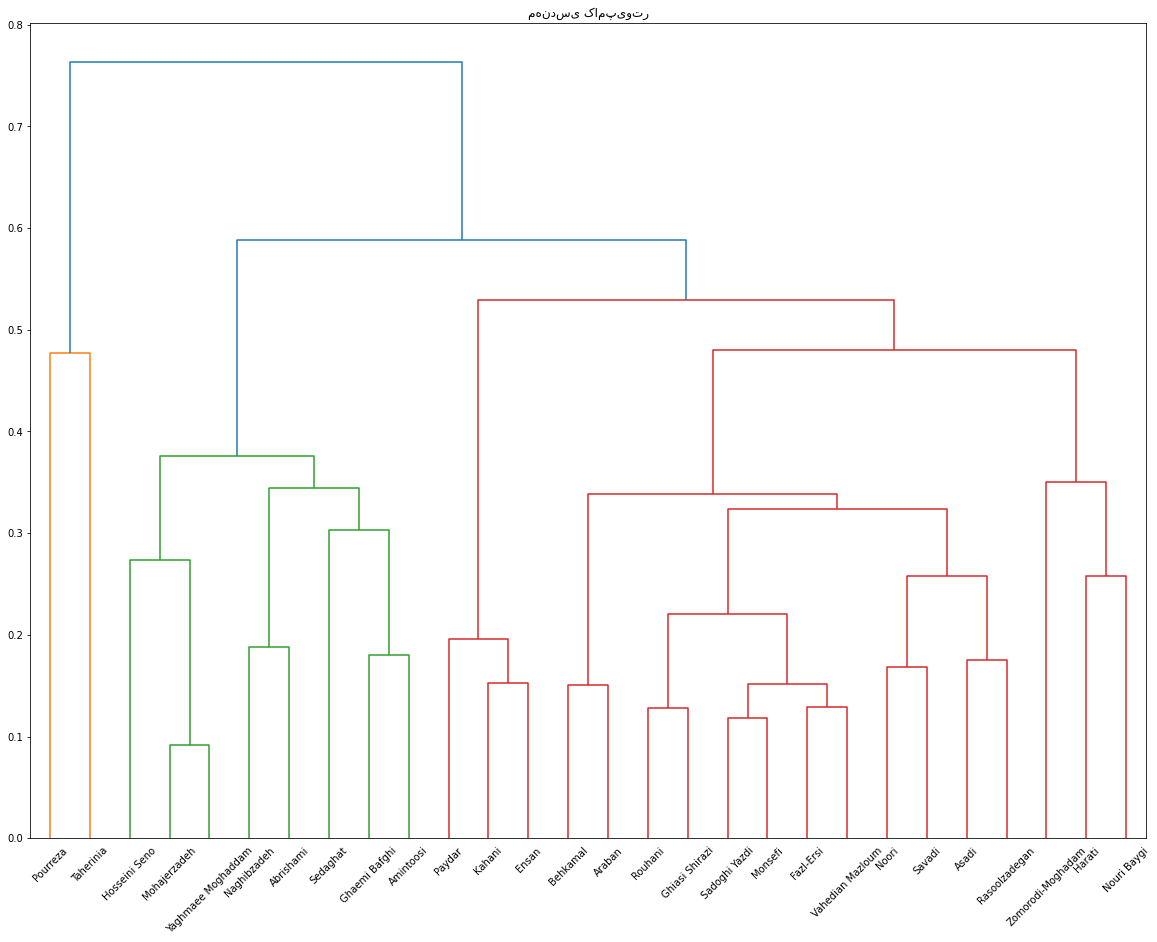

In [64]:
groups = main_dataset.groupby(by='گروه آموزشی')
iteration = 0
for grp, pdf in groups:
    fig = plt.figure(figsize=(20, 15))
    plt.title(grp)  
    dend = shc.dendrogram(shc.linkage(new_similarity_matrixs[iteration], method='complete'), labels=pdf['Family'].tolist())
    fig.savefig('Departments/complete/{}.jpg'.format(grp), format='jpg', bbox_inches='tight')    
    iteration += 1

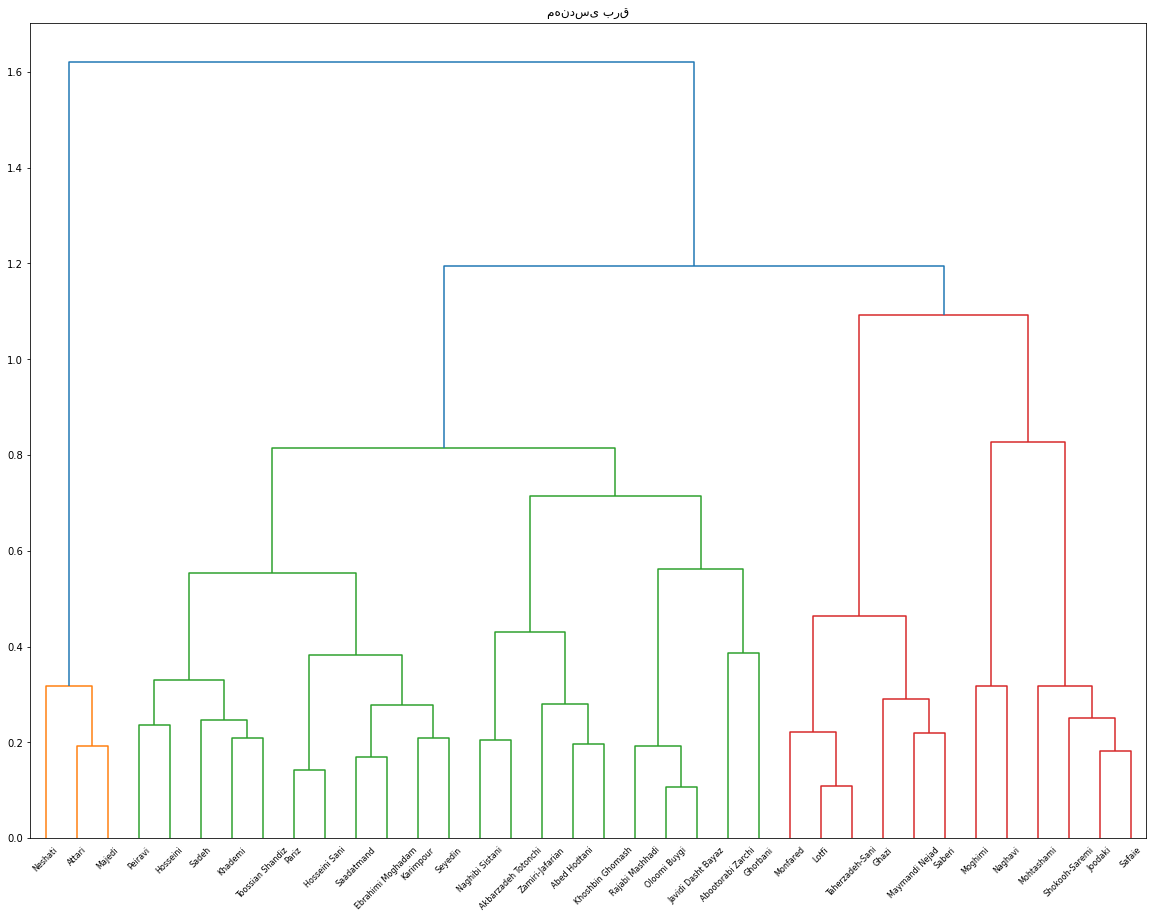

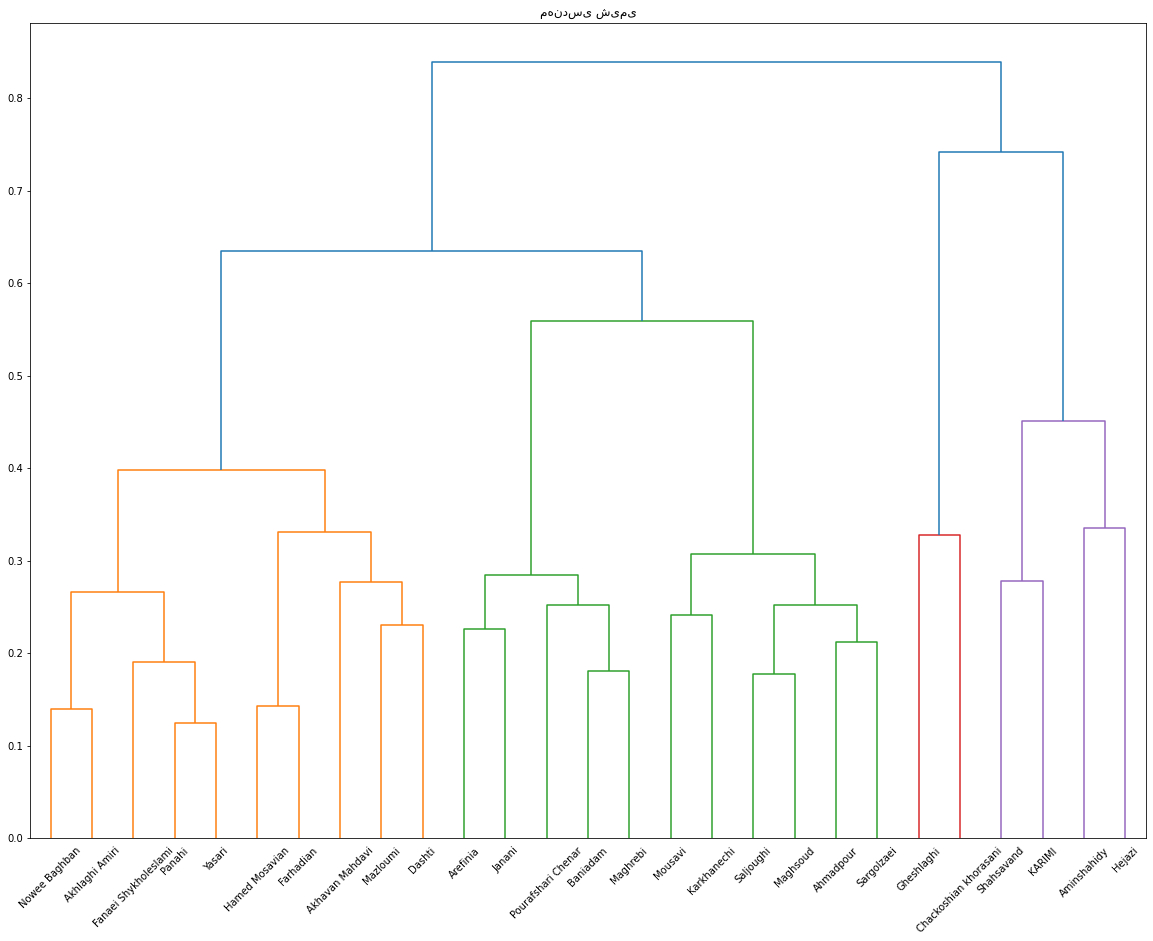

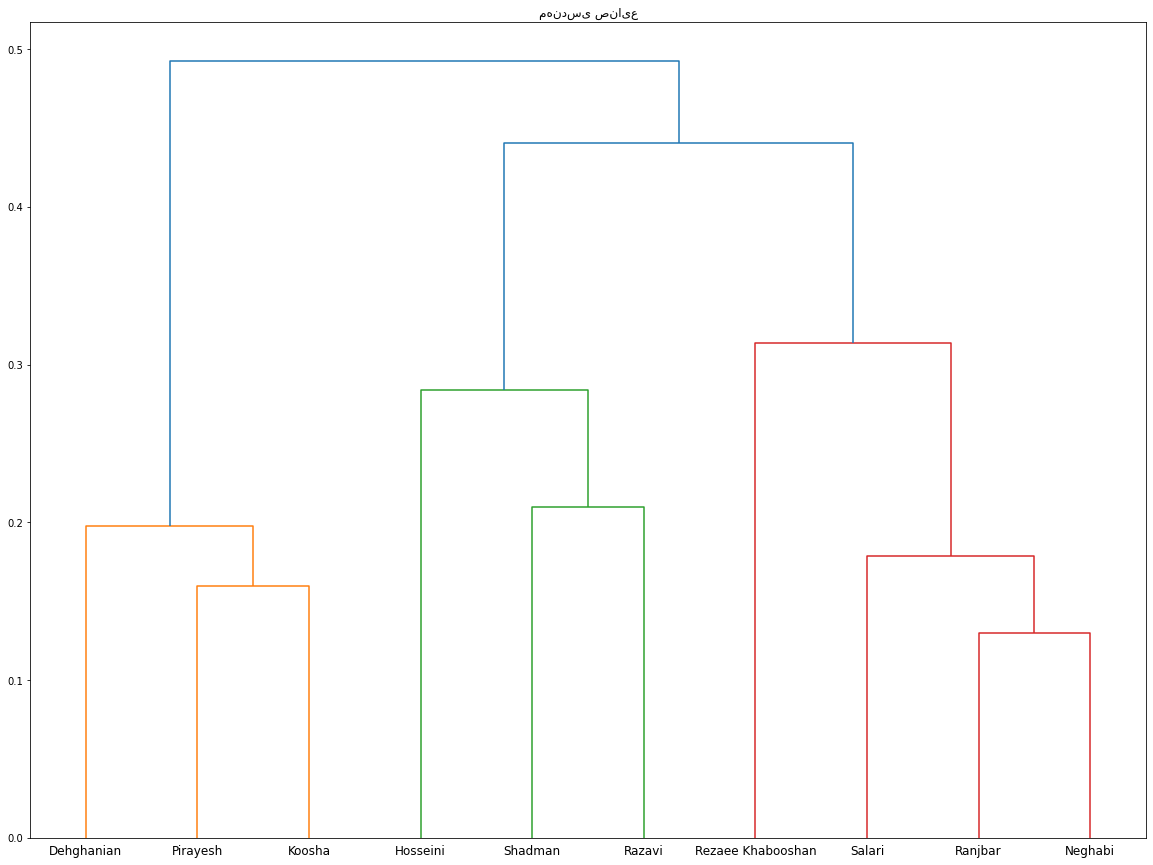

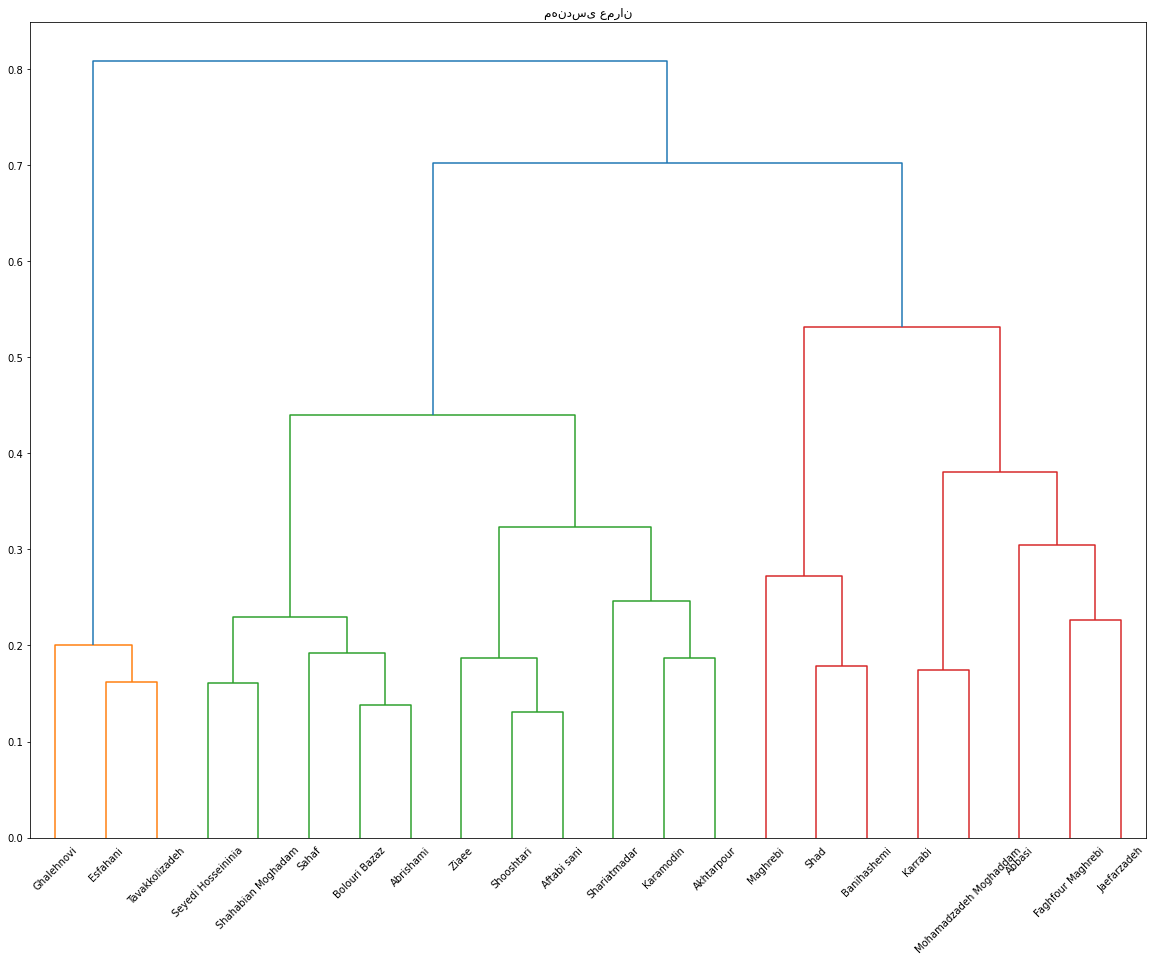

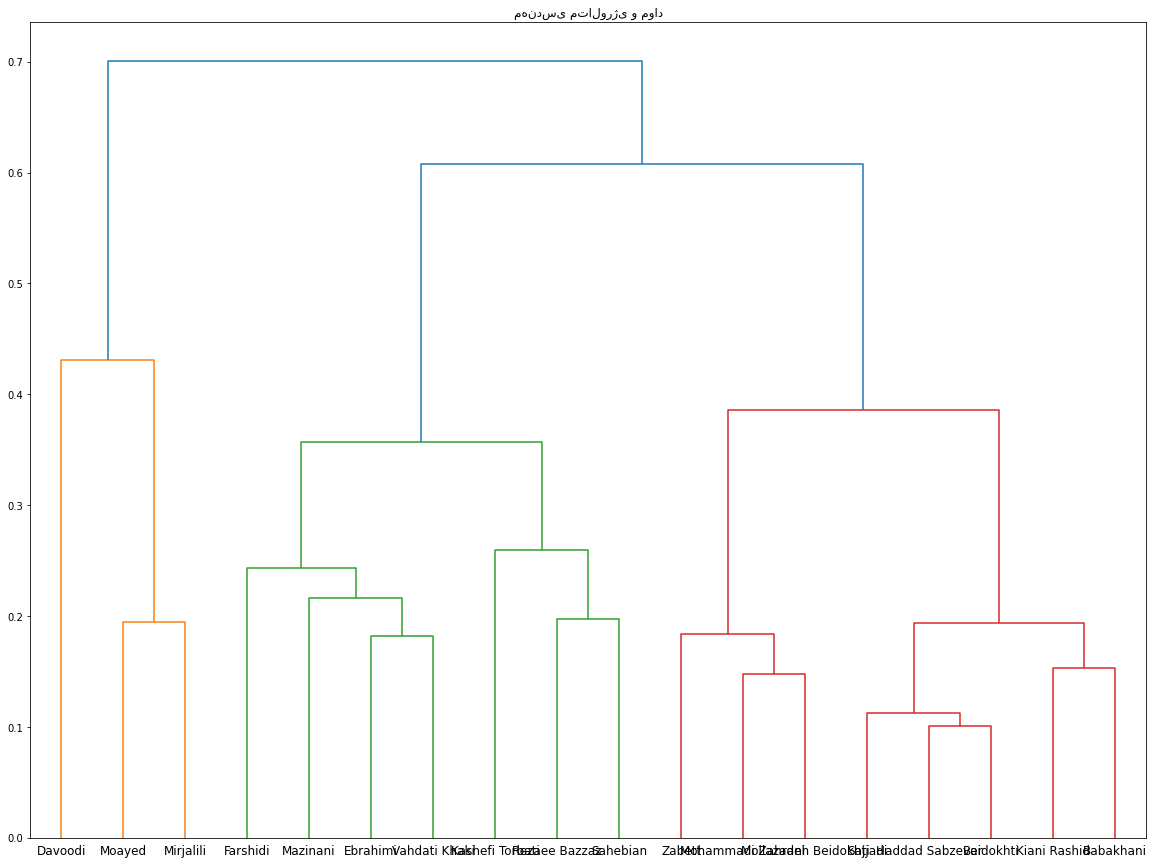

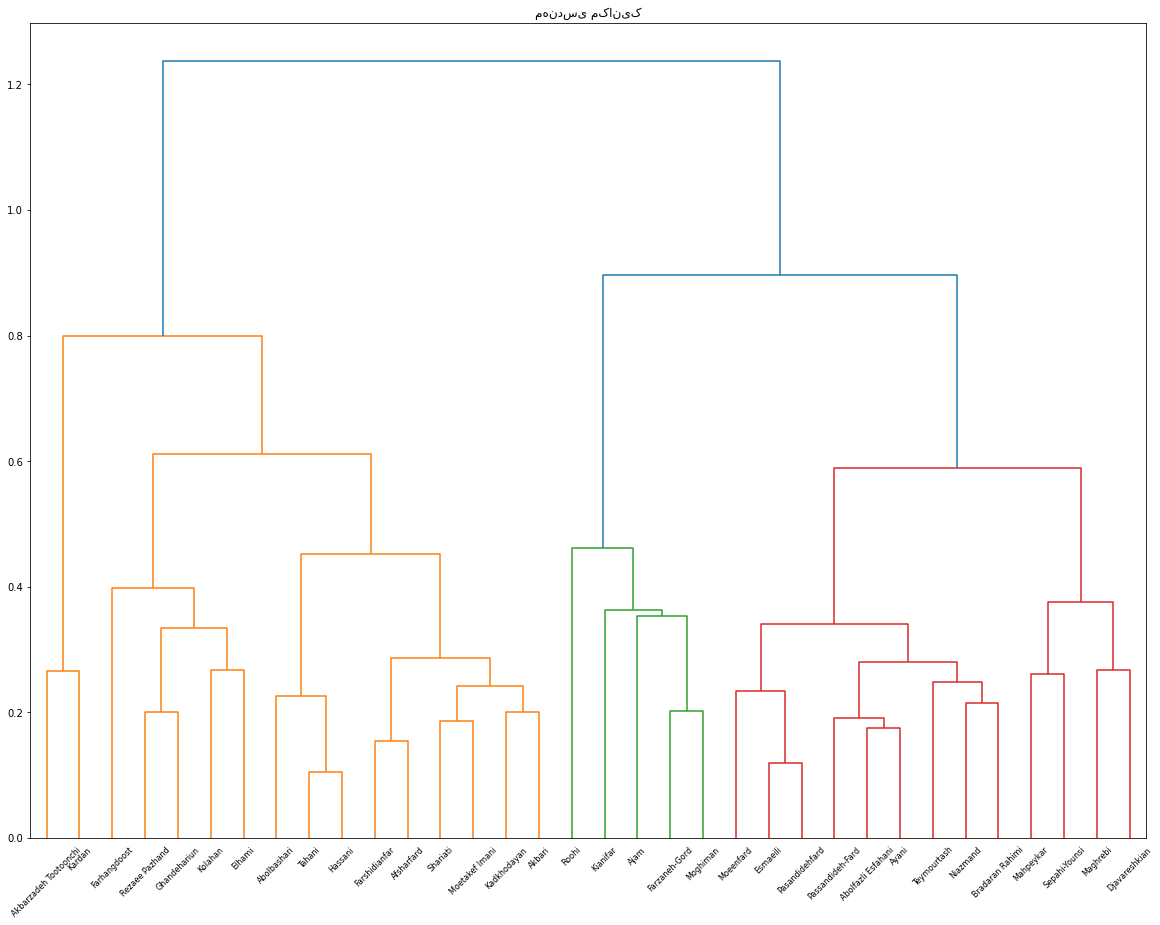

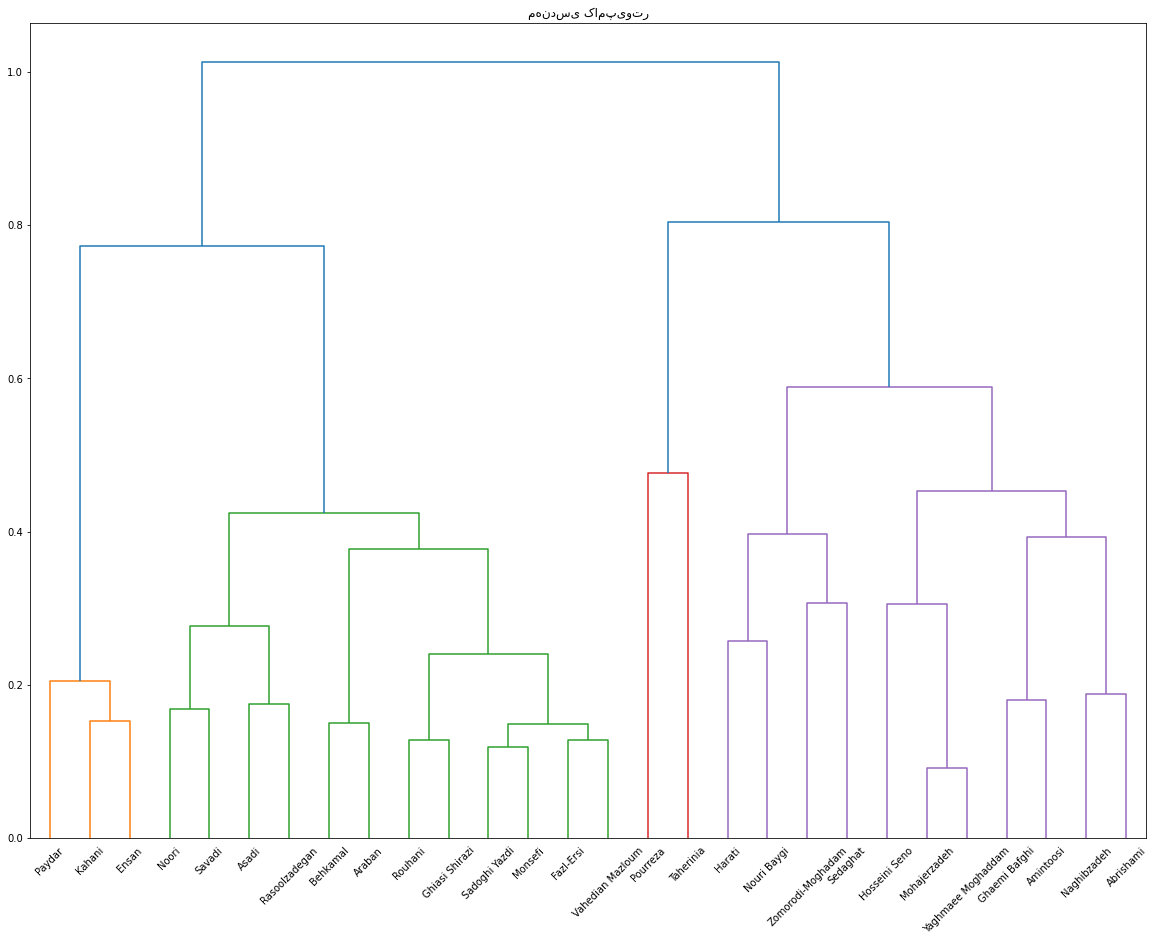

In [65]:
groups = main_dataset.groupby(by='گروه آموزشی')
iteration = 0
for grp, pdf in groups:
    fig = plt.figure(figsize=(20, 15))
    plt.title(grp)  
    dend = shc.dendrogram(shc.linkage(new_similarity_matrixs[iteration], method='ward'), labels=pdf['Family'].tolist())
    fig.savefig('Departments/ward/{}.jpg'.format(grp), format='jpg', bbox_inches='tight')    
    iteration += 1

In [ ]:
fig.savefig('EngFacultyComplete.jpg', format='jpg', bbox_inches='tight')

### Make a dendrogram with a cut-off on 5 levels

In [ ]:
# fig.savefig('cut_dendrogram2.jpg', format='jpg', bbox_inches='tight')

### Now I'm gonna use 'ward' method for clustering

In [ ]:
fig.savefig('EngFacultyWard.jpg', format='jpg', bbox_inches='tight')

### As u saw, It seems the 'complete' method is more suitable for our datas 
### But I'm not sure.

### Suppose that I'm right and  the 'complete' method is better at clustering these datas 
### So according to the dendrogram, It seems that theres 8 clusters

In [ ]:
model = AgglomerativeClustering(n_clusters=7, linkage='ward').fit(similarity_matrix)
main_dataset['cluster'] = model.labels_

### Now try to do grouping by, on clusters to have fields of each cluster togather

In [ ]:
groups = main_dataset.groupby(by=['cluster'])
groups.first()

In [ ]:
main_dataset['گروه آموزشی'].value_counts()

In [ ]:
for grp, pdf in groups:
    print("\n\nCluster: ", grp, "     Count: ", len(pdf))
    print(pd.DataFrame(pdf['گروه آموزشی']).value_counts())
    df = pd.DataFrame(pdf)
    
    with pd.ExcelWriter('EngineeringFacultyClustersWard.xlsx', mode='a') as writer:
        df.to_excel(writer, sheet_name='cluster ' + str(grp))

In [ ]:
# for grp, pdf in groups:
#     print("\n\nCluster: ", grp, "     Count: ", len(pdf))
#     print(('  -  '.join(set(('-'.join(set(pdf['Fields'].tolist()))).split('-')))).replace('\n', ' '))

#### Yohaa :) DID IT.